Train front cam with real life images to identify the following classes:

 ["Abydos Symbol", "Buoy", "Earth Symbol", "Gate", "Lane Marker", "Octagon Table"]

**Avoid runtime from disconnecting when training model:**

Copy paste the following into the console (ctrl + shift + i):
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#toolbar-add-code").click()
}setInterval(ClickConnect,120000)

https://maneeshkadanasseril.medium.com/how-to-stop-colab-from-disconnecting-2021-solution-ae5721e3838#:~:text=If%20you%20are%20not%20interacting,its%20runtime%20is%20automatically%20disconnected.&text=The%20only%20solution%20to,this%20is%20not%20always%20possible.

# Install dependencies, set up folder structure, import necessary librairies, generate data.yaml file

In [1]:
!pip install albumentations
!pip install opencv-python
!pip install ultralytics
!mkdir data
!mkdir data/augmented
# !mkdir data/raw
!mkdir data/augmented/train
!mkdir data/augmented/test
!mkdir data/augmented/val
!mkdir data/augmented/train/images
!mkdir data/augmented/test/images
!mkdir data/augmented/val/images
!mkdir data/augmented/train/labels
!mkdir data/augmented/test/labels
!mkdir data/augmented/val/labels
# !mkdir data/raw/images
# !mkdir data/raw/labels
# !rm -r sample_data

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.2/663.2 kB 5.7 MB/s eta 0:00:00


In [2]:
import os, shutil
from os import listdir
from os.path import isfile, join
import cv2
import albumentations as A
import copy
import random
import numpy as np
from ultralytics import YOLO
import torch
import shutil
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
with open('data.yaml', 'w+') as f:
    f.write("train: /content/data/augmented/train/images\n")
    f.write("test: /content/data/augmented/test/images\n")
    f.write("val: /content/data/augmented/val/images\n")
    f.write("nc: 6\n")
    f.write('names: ["Abydos Symbol", "Buoy", "Earth Symbol", "Gate", "Lane Marker", "Octagon Table"]')

# Augment data in /raw folder, put augmented dataset in /augmented folder

Define individual augmentation functions and image file input/ouput helper functions. Each augmentation is a function that expects a list of (image, label) tuples, and returns the original tuples as well as all augmented versions of each (image, label) tuple in a larger list.

In [4]:
#given a list of samples, make two copies of each sample that are darker/brighter to simulate differently lit environments
def brightnessAugment(images):
    out = []
    for image in images:
        transform = A.Compose([ A.augmentations.transforms.ColorJitter (brightness=(1.05, 1.05), contrast=0, saturation=0, hue=0, always_apply=True) ])
        bright_img = transform(image=image)["image"]
        transform = A.Compose([ A.augmentations.transforms.ColorJitter (brightness=(0.95, 0.95), contrast=0, saturation=0, hue=0, always_apply=True) ])
        dark_img = transform(image=image)["image"]
        out.append(bright_img)
        out.append(dark_img)
    return out

#given a list of samples, make a copy of each sample but more blurred to simulate objects out of focus, dirty lenses, and backscattering
def blurAugment(images):
    out = []
    for image in images:
        ksize = (10, 10) # lower to lower blur
        blurred_img = cv2.blur(image, ksize)
        out.append(blurred_img)
    return out

#given a list of samples, make a copy of each sample but with a lower contrast image to simulate backscattering and over/under-exposure
def contrastAugment(images):
    out = []
    for image in images:
        transform = A.Compose([ A.augmentations.transforms.ColorJitter (brightness=0, contrast=(0.1, 0.1), saturation=0, hue=0, always_apply=True) ])
        decontrasted_img = transform(image=image)["image"]
        out.append(decontrasted_img)
    return out

#given a list of samples, make a copy of each sample but with camera noise added to the image to simulate different camera feeds
def noiseAugment(images):
    out = []
    for image in images:
        transform = A.Compose([ A.augmentations.transforms.ISONoise(color_shift=(0.01, 0.01), intensity=(0.8, 0.8), always_apply=True) ])
        noisy_img = transform(image=image)["image"]
        out.append(noisy_img)
    return out

#given a list of samples, make a copy of each sample but with the image downscaled (lower resolution of image) to simulate lower quality cameras/images
def resolutionAugment(images):
    out = []
    for image in images:
        #interpolation=A.augmentations.transforms.Interpolation(downscale=cv2.INTER_NEAREST, upscale=cv2.INTER_NEAREST)
        transform = A.Compose([ A.augmentations.transforms.Downscale(scale_min=0.25, scale_max=0.25, always_apply=True) ])
        low_res_img = transform(image=image)["image"]
        out.append(low_res_img)
    return out

#increase intensity of blues in given image
def make_bluer(img, color_shift_intensity):
    img_b, img_g, img_r = cv2.split(img) #split by channel
    img_b = np.uint16(img_b)
    img_b += color_shift_intensity
    np.clip(img_b, 0, 255, out=img_b)
    img_b = np.uint8(img_b)
    img = cv2.merge((img_b, img_g, img_r)) #merge adjusted channels
    del img_b
    del img_g
    del img_r
    return img

#increase intensity of greens in given image
def make_greener(img, color_shift_intensity):
    img_b, img_g, img_r = cv2.split(img) #split by channel
    img_g = np.uint16(img_g)
    img_g += color_shift_intensity
    np.clip(img_g, 0, 255, out=img_g)
    img_g = np.uint8(img_g)
    img = cv2.merge((img_b, img_g, img_r)) #merge adjusted channels
    del img_b
    del img_g
    del img_r
    return img

#given a list of samples, make two copies of each sample (one bluer, one greener) to simulate different pools + color attenuation
def colorAugment(images):
    out = []
    color_shift_intensity = int(255*0.1)
    for image in images:
        blue_img = make_bluer(image, color_shift_intensity)
        green_img = make_greener(image, color_shift_intensity)
        out.append(blue_img)
        out.append(green_img)
    return out

#remove all files/folders in folder
def clearFolder(folder):
    #get all directory/filenames in folder
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                #delete all files
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                #recursively delete everything in sub-folders
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))

#output given samples to given folder so that each image has corresponding label with same filename in /images and /labels subfolders respectively
def sendToFolders(samples, output_folder):
    #remove all files/folders in output folders
    clearFolder(output_folder + "/images")
    clearFolder(output_folder + "/labels")
    instance_count = 0 #keep track of instance count for filename
    for sample in samples:
        image, label = sample
        #write image to file in /images
        cv2.imwrite(output_folder + '/images/img' + str(instance_count) + '.png', image)
        #write label to file in /labels
        with open(output_folder + '/labels/img' + str(instance_count) + '.txt', 'w+') as f:
            #each box gets its own line
            for box in label:
                f.write(box)
        instance_count += 1

#given array of image/label arrays, and an integer of how to split the data, returns the dataset split accordingly
def splitData(samples, splits):
    #for now we just shuffle the data to hopefully get a similar sample size
    # of images for every class in the train, test and val splits
    #ideally in the future we should split by class and then combine together to make sure the datasets are balanced

    #shuffle data
    random.shuffle(samples)
    #get indices for split
    splits = [int(len(samples)*s) for s in splits]
    #return split data
    return samples[:splits[0]], samples[splits[0]:splits[0]+splits[1]], samples[splits[0]+splits[1]:]

#given a single image and augmentation function, displays the image before and images after augmentation
def visualizeAugmentation(img, aug):
    #show original image
    cv2.imshow('og', img)
    cv2.waitKey(0)
    #show all augmented images
    for augmented in aug([(img, "")])[1:]:
        cv2.imshow('augmented',augmented[0])
        cv2.waitKey(0)

#given source dataset folder, loads all images and labels into arrays
def loadInputData(source_folder):
    samples = []
    #get all filenames in the /images subfolder of given source_folder
    img_filenames = [f for f in listdir(source_folder + '/images') if isfile(join(source_folder + '/images', f))]
    for img_filename in img_filenames:
        #load image at that filename
        img = cv2.imread(source_folder + '/images/' + img_filename)
        #got label filename corresponding to the image
        label_filename = os.path.splitext(img_filename)[0] + ".txt"
        #load in the label file contents
        with open(source_folder + "/labels/" + label_filename) as f:
            #build array of bounding boxes (each line its own element)
            bounding_boxes = []
            for line in f.read().split("\n"):
                bounding_boxes.append(line)
        #add image and label to sample set
        samples.append( (img, bounding_boxes) )
    del img_filenames
    return samples


In [5]:
def get_file_names(source_folder):
    label_filenames = []
    img_filenames = [f for f in listdir(source_folder + '/images') if isfile(join(source_folder + '/images', f))]
    for img_filename in img_filenames:
        label_filenames.append(os.path.splitext(img_filename)[0] + ".txt")

    return np.array(img_filenames), np.array(label_filenames)

def split_file_names(images,labels,splits):
    perm = np.random.permutation(len(images))
    images = images[perm]
    labels = labels[perm]
    splits = [int(len(images)*s) for s in splits]
    train_images = images[:splits[0]]
    train_labels = labels[:splits[0]]
    val_images = images[splits[0]: splits[0] + splits[1]]
    val_labels = labels[splits[0]: splits[0] + splits[1]]
    test_images = images[splits[0] + splits[1]:]
    test_labels = labels[splits[0] + splits[1]:]
    return train_images, train_labels, val_images, val_labels, test_images, test_labels

def get_augs(img_filename,source_folder):
    img = cv2.imread(source_folder + '/images/' + img_filename)
    prob = 0.5
    augs = [img]
    if(np.random.rand() > prob):
        augs = augs + colorAugment([img])
    if(np.random.rand() > prob):
        augs = augs + brightnessAugment(augs)
    if(np.random.rand() > prob):
        augs = augs + contrastAugment(augs)
    if(np.random.rand() > prob):
        augs = augs + blurAugment(augs)
    return augs

def do_augs_and_export(img_filenames,label_filenames,source_folder,output_folder):
    name_num = 1
    for (img_filename,label_filename) in zip(img_filenames,label_filenames):
        augs = get_augs(img_filename,source_folder)
        with open(source_folder + "/labels/" + label_filename) as f:
            #build array of bounding boxes (each line its own element)
            bounding_boxes = f.read()
        for aug in augs:
            cv2.imwrite(output_folder + '/images/img' + str(name_num) + '.png', aug)
            with open(output_folder + '/labels/img' + str(name_num) + '.txt',"w+") as f:
                f.write(bounding_boxes)
            name_num+=1

In [6]:
#Get data from roboflow: Go to Versions > Export Dataset > Choose Format: YOLOv5 > Click "show download code" > Continue > Copy-paste the download code below
#Change name of folder --> write code to do this after

!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="") 
project = rf.workspace("auv2024").project("front-cam-real")
dataset = project.version(2).download("yolov5")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 8.2 MB/s eta 0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.1
    Uninstalling pyparsing-3.1.1:
      Successfully uninstalled pyparsing-3.1.1
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.8.1.78
    Uninstalling opencv-python-headless-4.8.1.78:
      Successfully uninstal

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Front-cam-real-2 in yolov5pytorch:: 100%|██████████| 1824/1824 [00:00<00:00, 4074.97it/s]


In [7]:
#Rename/move the images
!rm -r sample_data
!mv /content/Front-cam-real-2/train/ /content/data/raw
!rm -r Front-cam-real-1



rm: cannot remove 'Front-cam-real-1': No such file or directory


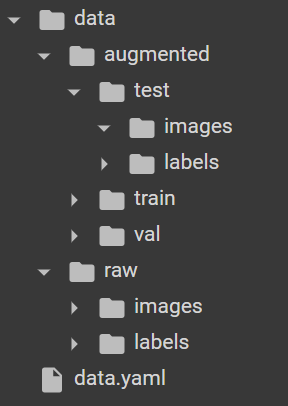)

In [8]:
train_test_val_split = (0.7, 0.2, 0.1)
out_folder = "data/augmented"
in_folder = "data/raw"

img_names, label_names = get_file_names(in_folder)
train_images, train_labels, val_images, val_labels, test_images, test_labels = split_file_names(img_names,label_names,train_test_val_split)
do_augs_and_export(train_images,train_labels,in_folder,out_folder + "/train")
do_augs_and_export(val_images,val_labels,in_folder,out_folder + "/val")
do_augs_and_export(test_images,test_labels,in_folder,out_folder + "/test")


Load in all files from /raw folder, pass list of images sequentially through each augmentation function, then output final images to /augmented folder

In [9]:
# train_test_val_split = (0.7, 0.2, 0.1)
# out_folder = "data/augmented"
# in_folder = "data/raw"

# print("Loading data...")
# data = loadInputData(in_folder)

#FOR TESTING uncomment to visualize individual augmentations
#visualizeAugmentation(data[0][0], colorAugment)
#exit()

In [10]:
# def do_all_augs(stuff):
#     stuff = colorAugment(stuff)
#     stuff = brightnessAugment(stuff)
#     sutff = contrastAugment(stuff)
#     return blurAugment(stuff)

# train, test, val = splitData(data, train_test_val_split)

# # print("Augmenting color...")
# data = colorAugment(data) # times 3
# print("Augmenting brightness...")
# data = brightnessAugment(data) # times 3
# print("Augmenting contrast...")
# data = contrastAugment(data) # times 2
# #print("Augmenting blur...")
# #data = blurAugment(data) # times 2
# print("Splitting data...")

# train = do_all_augs(train)
# test = do_all_augs(test)
# val = do_all_augs(val)

# print("Exporting training data...")
# sendToFolders(train, out_folder + "/train")
# print("Exporting test data...")
# sendToFolders(test, out_folder + "/test")
# print("Exporting val data...")
# sendToFolders(val, out_folder + "/val")
# print("Done. Final number of samples: " + str(len(data)))

# Train YOLO model with augmented data

In [11]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
#Ensure this prints true and a number > 0, if not make sure you set hardware accelerator to GPU in Edit > Notebook Settings > Hardware Accelerator
# !rm -r runs/detect/train*
!mkdir runs
!mkdir runs/detect
!mkdir runs/detect/train

True
1


In [13]:
#UNCOMMENT TO START FROM SCRATCH
torch.cuda.empty_cache()
#model = YOLO("yolov8n.pt")  # load a pretrained model
#model = YOLO("runs/detect/train11/weights/last.pt")
# CONTINUE TRAINING
model = YOLO("/content/best (3).pt") #load a previous model in case training interrupts

# Train the model in increments
epoch_increments = 60
# while True:
model.train(data="data.yaml", epochs=epoch_increments, device=0, batch=16, degrees=360, flipud=0.5, fliplr=0.5, perspective=0.001, translate=0.1, scale=0.3,mosaic=0.5,mixup=0.5, pretrained=True, task='detect')  # train the model
model.val()
#shutil.copyfile("runs/detect/train" + str(i) + "/weights/best.pt", "/content/drive/My Drive/AUV_model_" + str(i) + ".pt")


Ultralytics YOLOv8.0.231 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/content/best (3).pt, data=data.yaml, epochs=60, time=None, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None,

100%|██████████| 755k/755k [00:00<00:00, 17.1MB/s]



                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

100%|██████████| 6.23M/6.23M [00:00<00:00, 81.8MB/s]


WARNING ⚠️ NMS time limit 0.550s exceeded
AMP: checks passed ✅


train: Scanning /content/data/augmented/train/labels... 5824 images, 185 backgrounds, 0 corrupt: 100%|██████████| 5824/5824 [00:29<00:00, 194.57it/s]


train: New cache created: /content/data/augmented/train/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 7361, len(boxes) = 23735. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/data/augmented/val/labels... 1616 images, 39 backgrounds, 0 corrupt: 100%|██████████| 1616/1616 [00:10<00:00, 158.40it/s]


val: New cache created: /content/data/augmented/val/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 2517, len(boxes) = 6803. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
60 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/60       2.6G        1.2     0.9395      1.356        115        640: 100%|██████████| 364/364 [05:54<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:48<00:00,  1.04it/s]

                   all       1616       6803       0.94      0.888      0.917      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/60      2.18G      1.202     0.9287      1.359        149        640: 100%|██████████| 364/364 [05:43<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:48<00:00,  1.06it/s]

                   all       1616       6803      0.942      0.865        0.9      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/60      2.21G      1.226     0.9643      1.382        143        640: 100%|██████████| 364/364 [05:39<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:47<00:00,  1.08it/s]

                   all       1616       6803       0.93      0.858      0.903      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/60      2.28G      1.216     0.9512      1.368        107        640: 100%|██████████| 364/364 [05:40<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:47<00:00,  1.07it/s]


                   all       1616       6803      0.922       0.84      0.875      0.632

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/60       2.2G      1.229      0.959      1.374        152        640: 100%|██████████| 364/364 [05:35<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:48<00:00,  1.05it/s]


                   all       1616       6803      0.902      0.839      0.871       0.62

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/60      2.29G      1.228     0.9653       1.38        156        640: 100%|██████████| 364/364 [05:39<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:47<00:00,  1.08it/s]


                   all       1616       6803       0.94      0.833      0.884      0.647

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/60      2.23G       1.21     0.9497      1.367        113        640: 100%|██████████| 364/364 [05:39<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:46<00:00,  1.09it/s]


                   all       1616       6803      0.905      0.846      0.883      0.635

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/60      2.17G      1.205     0.9372      1.366        131        640: 100%|██████████| 364/364 [05:43<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:47<00:00,  1.07it/s]

                   all       1616       6803      0.905      0.867      0.893       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/60      2.19G      1.214     0.9241      1.361        166        640: 100%|██████████| 364/364 [05:41<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:49<00:00,  1.03it/s]


                   all       1616       6803      0.928      0.846      0.893      0.649

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/60      2.26G      1.183     0.9134      1.347        152        640: 100%|██████████| 364/364 [05:34<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:45<00:00,  1.13it/s]

                   all       1616       6803      0.933      0.861      0.892      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/60      2.25G      1.196     0.9272       1.36        155        640: 100%|██████████| 364/364 [05:30<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:45<00:00,  1.11it/s]


                   all       1616       6803      0.905      0.842      0.861      0.594

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/60      2.31G      1.195     0.9202      1.359        176        640: 100%|██████████| 364/364 [05:30<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:46<00:00,  1.11it/s]


                   all       1616       6803      0.919      0.851      0.895      0.644

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/60      2.29G      1.191     0.9185      1.358        172        640: 100%|██████████| 364/364 [05:23<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:45<00:00,  1.11it/s]


                   all       1616       6803      0.908      0.827      0.877      0.645

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/60      2.23G      1.183     0.9093      1.349        161        640: 100%|██████████| 364/364 [05:24<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:45<00:00,  1.12it/s]


                   all       1616       6803      0.915      0.869      0.884      0.639

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/60       2.2G      1.172     0.9023      1.336        136        640: 100%|██████████| 364/364 [05:28<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:47<00:00,  1.07it/s]


                   all       1616       6803      0.935      0.855       0.89      0.654

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/60      2.23G      1.171     0.8896      1.337        129        640: 100%|██████████| 364/364 [05:38<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:49<00:00,  1.03it/s]


                   all       1616       6803      0.941       0.85      0.894      0.681

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/60      2.29G      1.164     0.8895      1.336        176        640: 100%|██████████| 364/364 [05:29<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:46<00:00,  1.09it/s]


                   all       1616       6803      0.907      0.859      0.886      0.671

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/60      2.23G      1.154     0.8744      1.329        140        640: 100%|██████████| 364/364 [05:26<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:45<00:00,  1.12it/s]

                   all       1616       6803       0.92      0.854      0.887      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/60       2.2G      1.156     0.8545      1.318        167        640:  14%|█▍        | 52/364 [00:44<04:26,  1.17it/s]


KeyboardInterrupt: ignored

In [14]:
def visualizeBbox(img, bbox, class_name, thickness=2, fontSize=0.5):
    #get xmin, xmax, ymin, ymax from bbox
    BOX_COLOR=(0,255,0)
    TEXT_COLOR = (0,0,0)
    x_center, y_center, w, h = bbox
    x_min = x_center - w/2
    y_min = y_center - h/2
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)
    #draw bounding box on image
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=BOX_COLOR, thickness=thickness)
    #get size of class name text
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, fontSize, 1)
    #draw box around class name label on image
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    #put class name text in the box we drew
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=fontSize,
        color=TEXT_COLOR,
        lineType=cv2.LINE_AA,
    )
    return img

# Predict on image with model

In [26]:
img_path = "data/augmented/test/images/img218.png"
img = cv2.imread(img_path)
# Load a model
model = YOLO("runs/detect/train2/weights/best.pt")  # load a model
# Use the model
pred = model(img)
for results in pred:
    box = results.boxes
    print(box)
    print("\nprediction:" + str(list(box.xywh)))
    print("\nprediction:" + str(list(box.conf)))
    print("\nprediction:" + str(list(box.cls)))

points = box.xywh.tolist()[0] #If no bounding box, this will throw an exception
boxed = visualizeBbox(img,points,"gate") #Will label everything as "gate". TODO: Make this label the correct class
cv2.imwrite("test1.png",boxed)


0: 480x640 1 Abydos Symbol, 1 Buoy, 1 Earth Symbol, 8.4ms
Speed: 1.3ms preprocess, 8.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([2., 1., 0.], device='cuda:0')
conf: tensor([0.8791, 0.8141, 0.7556], device='cuda:0')
data: tensor([[ 16.4217,  44.8862, 145.8840, 160.6873,   0.8791,   2.0000],
        [  0.0000,   0.0000, 176.1342, 341.9371,   0.8141,   1.0000],
        [ 49.9209, 177.4036, 107.7048, 311.6212,   0.7556,   0.0000]], device='cuda:0')
id: None
is_track: False
orig_shape: (480, 640)
shape: torch.Size([3, 6])
xywh: tensor([[ 81.1529, 102.7867, 129.4623, 115.8011],
        [ 88.0671, 170.9685, 176.1342, 341.9371],
        [ 78.8128, 244.5124,  57.7839, 134.2177]], device='cuda:0')
xywhn: tensor([[0.1268, 0.2141, 0.2023, 0.2413],
        [0.1376, 0.3562, 0.2752, 0.7124],
        [0.1231, 0.5094, 0.0903, 0.2796]], device='cuda:0')
xyxy: tensor([[ 16.4217,  44.8862, 145.8840, 160.6873],

True

In [16]:
model.export()

Ultralytics YOLOv8.0.231 🚀 Python-3.10.12 torch-2.1.0+cu121 CPU (Intel Xeon 2.30GHz)

PyTorch: starting from 'runs/detect/train2/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 10, 8400) (35.0 MB)

TorchScript: starting export with torch 2.1.0+cu121...
TorchScript: export success ✅ 3.2s, saved as 'runs/detect/train2/weights/best.torchscript' (11.9 MB)

Export complete (5.2s)
Results saved to /content/runs/detect/train2/weights
Predict:         yolo predict task=detect model=runs/detect/train2/weights/best.torchscript imgsz=640  
Validate:        yolo val task=detect model=runs/detect/train2/weights/best.torchscript imgsz=640 data=data.yaml  
Visualize:       https://netron.app


'runs/detect/train2/weights/best.torchscript'

Make a confusion matrix

In [33]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip install git+https://github.com/Supervisor/supervisor.git

  Cloning https://github.com/Supervisor/supervisor.git to /tmp/pip-req-build-7y3ji_5y
  Running command git clone --filter=blob:none --quiet https://github.com/Supervisor/supervisor.git /tmp/pip-req-build-7y3ji_5y
  Resolved https://github.com/Supervisor/supervisor.git to commit ff5356f65ebc557554bbe1b39a1f320ab346d064
  Preparing metadata (setup.py) ... done
  Created wheel for supervisor: filename=supervisor-4.3.0.dev0-py2.py3-none-any.whl size=319851 sha256=95e130bdaa040e1f9e8cc33d011fbfad9749442f6fb338ea531e86ce32766870
  Stored in directory: /tmp/pip-ephem-wheel-cache-z6v4zjgp/wheels/01/e9/20/d9720fc29dd78fa61308d29acde13c42142d2b66ccd74c6972
Successfully built supervisor



0: 384x640 3 Abydos Symbols, 5 Earth Symbols, 1 Octagon Table, 19.0ms
Speed: 27.5ms preprocess, 19.0ms inference, 15.1ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 2 Abydos Symbols, 1 Buoy, 2 Earth Symbols, 1 Gate, 17.3ms
Speed: 2.8ms preprocess, 17.3ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 1 Abydos Symbol, 1 Earth Symbol, 1 Gate, 14.5ms
Speed: 4.1ms preprocess, 14.5ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 Abydos Symbols, 4 Earth Symbols, 1 Octagon Table, 8.9ms
Speed: 2.6ms preprocess, 8.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 640x640 2 Abydos Symbols, 1 Buoy, 2 Earth Symbols, 17.5ms
Speed: 4.9ms preprocess, 17.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Abydos Symbol, 1 Earth Symbol, 1 Gate, 10.5ms
Speed: 4.7ms preprocess, 10.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 Gate, 9.7m

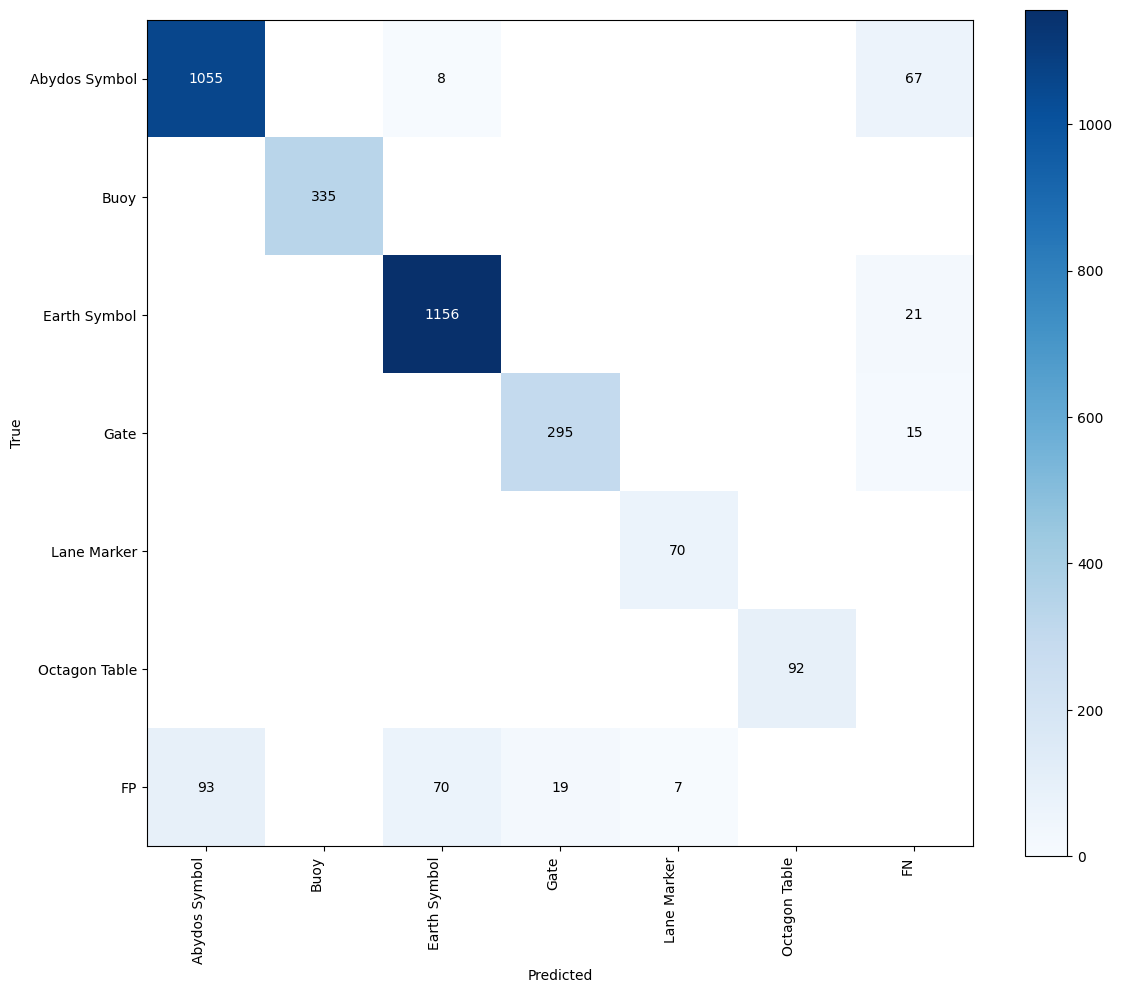

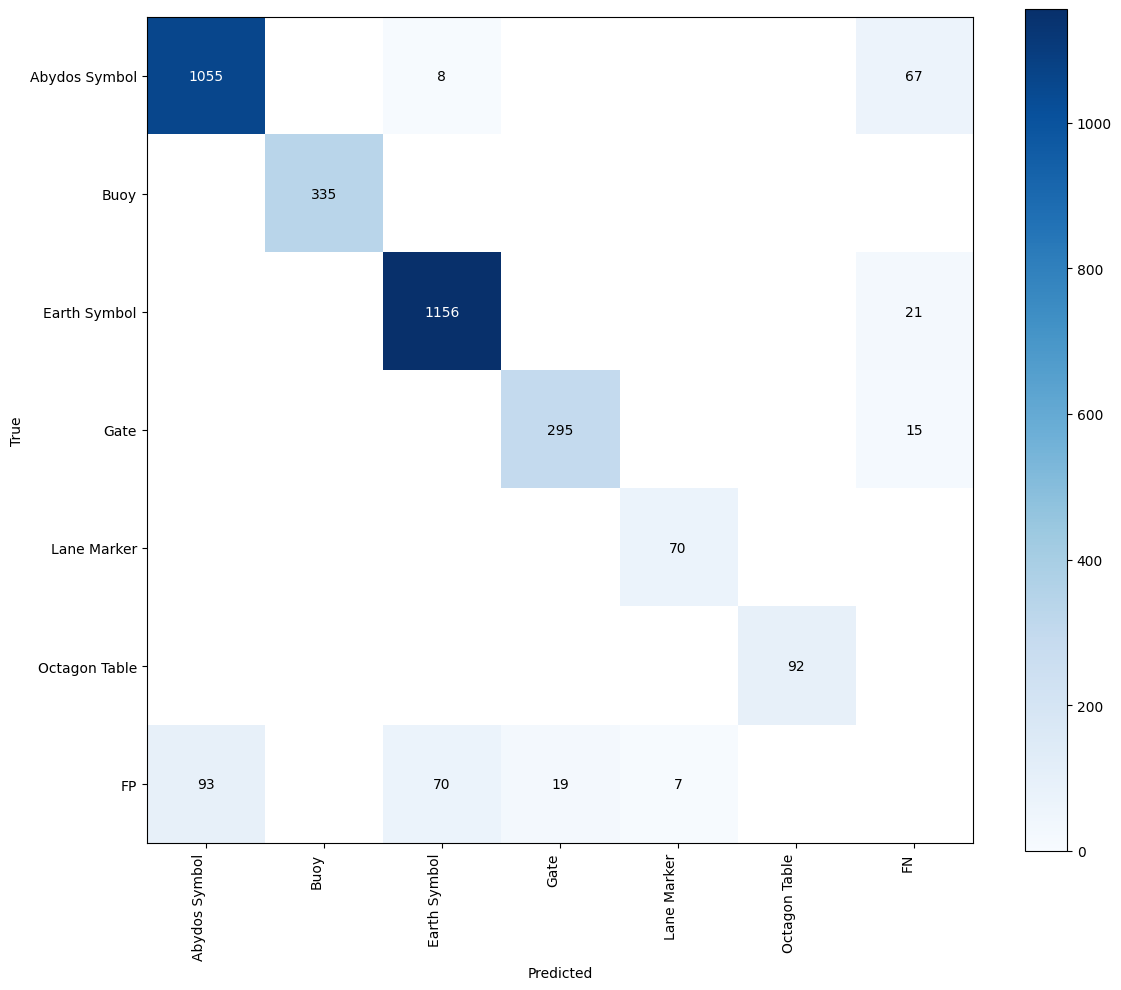

In [41]:
import supervision as sv
dataset = sv.DetectionDataset.from_yolo(
    images_directory_path="/content/data/augmented/test/images",
    annotations_directory_path="/content/data/augmented/test/labels",
    data_yaml_path="/content/data/data.yaml"
)

model = YOLO("runs/detect/train2/weights/best.pt")
def callback(image: np.ndarray) -> sv.Detections:
    result = model(image)[0]
    return sv.Detections.from_ultralytics(result)

confusion_matrix = sv.ConfusionMatrix.benchmark(
   dataset = dataset,
   callback = callback
)

confusion_matrix.plot()